# Sprint
## ディープラーニングフレームワーク2

## 1.このSprintについて

### Sprintの目的
- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

### どのように学ぶか
前半はTensorFlowのExampleを動かします。後半ではKerasのコードを書いていきます。

In [1]:
# library
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

## 2.公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

### 【問題1】
#### 公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


[models/tutorials at master · tensorflow/models](https://www.tensorflow.org/tutorials)

#### Kerasによる分散トレーニング

In [2]:
tf.reset_default_graph()

In [3]:
# mnistデータセットの読み込み
tfds.disable_progress_bar()
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

In [4]:
# 利用可能デバイス探索
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos]

In [5]:
get_available_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8140574946194694337]

In [6]:
# 複数GPUでの計算を可能にするAPI
# このスコープ内でモデルを作成すると分散処理ができる
strategy = tf.distribute.MirroredStrategy(devices=['/cpu:0'])

In [7]:
# デバイス数表示
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [8]:
# データ分割
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [9]:
# スケーリング
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

In [10]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

In [11]:
# model作成
# strategyのスコープ内で作成することで計算をうまく複数デバイスに分散してくれる
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
# checkpoint作成
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [13]:
# 学習率をエポックごとに変更する
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [14]:
# 学習率を表示する
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [15]:
# コールバック設定
callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [16]:
# 学習
# model.fit(train_dataset, epochs=12, callbacks=callbacks)

-> localだとうまく動かない/CPU1基のみなのでGoogle Colabを利用: ./keras_distribute.ipynb

### 【問題2】
#### （アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。


なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。


[models/research at master · tensorflow/models]()


[google-research/google-research: Google AI Research]()


更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

## 3.異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。


- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

### Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。


KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

### 【問題3】
#### Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [17]:
# dataset読み込み
df_iris = pd.read_csv('Iris.csv')
display(df_iris)
X = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 1:5])
y = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 5])
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
display(X.shape)
display(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


(100, 4)

(100, 1)

(64, 4) (64, 1)
(16, 4) (16, 1)
(20, 4) (20, 1)


In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(5, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.03),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 0s 4ms/sample - loss: 0.4242 - acc: 0.8125 - val_loss: 0.0420 - val_acc: 1.0000
Epoch 2/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.1144 - acc: 0.9531 - val_loss: 0.0866 - val_acc: 0.9375
Epoch 3/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.0836 - acc: 0.9688 - val_loss: 0.0987 - val_acc: 0.9375
Epoch 4/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.0289 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 5/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.0319 - acc: 0.9844 - val_loss: 0.1492 - val_acc: 0.9375
Epoch 6/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.0409 - acc: 0.9844 - val_loss: 0

In [21]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print("y_test", y_test.flatten())

y_pred_proba [6.5353513e-04 1.0000000e+00 6.1103702e-04 1.0000000e+00 1.0000000e+00
 1.0000000e+00 2.1481514e-04 9.9960184e-01 1.0000000e+00 1.0000000e+00
 1.0000000e+00 9.9999988e-01 1.0000000e+00 4.2793155e-04 0.0000000e+00
 0.0000000e+00 8.9575833e-01 1.2814999e-06 9.9995333e-01 2.0921230e-05]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


### 【問題4】
#### Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [22]:
# 抽出
X = np.array(df_iris.iloc[:, 1:5])
y = np.array(pd.get_dummies(df_iris.iloc[:, 5]))
y = y.astype(np.int)
display(X.shape)
display(y.shape)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(150, 4)

(150, 3)

(96, 4) (96, 3)
(24, 4) (24, 3)
(30, 4) (30, 3)


In [23]:
# モデル構築
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))
model.summary()

# コンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.03),
              metrics=['accuracy'])

# 学習
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 1,543
Trainable params: 1,543
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 2ms/sample - loss: 0.5897 - acc: 0.8021 - val_loss: 0.3130 - val_acc: 0.8750
Epoch 2/10
96/96 [==============================] - 0s 2ms/sample - loss: 0.4551 - acc: 0.9062 - val_loss: 0.2427 - val_acc: 0.9167
Epoch 3/10
96/96 [==============================] - 0s 2ms/sample - loss: 0.

In [24]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print("y_test", np.argmax(y_test, axis=1))

y_pred_proba [[1.3322644e-09 3.0437014e-01 6.9562984e-01]
 [2.1102066e-04 9.9788874e-01 1.9002205e-03]
 [1.0000000e+00 0.0000000e+00 8.9128140e-27]
 [1.6556097e-03 8.1835383e-01 1.7999050e-01]
 [1.0000000e+00 5.6482033e-32 7.4052302e-21]
 [1.9489766e-13 9.8898217e-02 9.0110177e-01]
 [1.0000000e+00 5.7513239e-33 1.7498283e-21]
 [2.8673441e-03 9.8445052e-01 1.2682107e-02]
 [2.1001108e-03 9.8835677e-01 9.5430175e-03]
 [1.0392122e-03 9.9183756e-01 7.1232389e-03]
 [3.7480392e-02 8.5434127e-01 1.0817821e-01]
 [3.2238055e-03 9.8099434e-01 1.5781913e-02]
 [1.8574912e-03 9.8572332e-01 1.2419293e-02]
 [1.0397405e-02 9.5760596e-01 3.1996641e-02]
 [1.1976196e-02 9.4360131e-01 4.4422537e-02]
 [1.0000000e+00 2.7207004e-29 3.6620149e-19]
 [1.9804521e-02 9.1809434e-01 6.2101174e-02]
 [7.0870682e-03 9.6572101e-01 2.7191881e-02]
 [1.0000000e+00 7.4953040e-26 5.4471167e-17]
 [1.0000000e+00 1.4670540e-35 4.0299606e-23]
 [4.6910272e-06 6.2480384e-01 3.7519151e-01]
 [3.6118742e-02 8.5799110e-01 1.0589018e-0

### 【問題5】
#### House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [25]:
# 読み込み
df_price = pd.read_csv('train.csv')
display(df_price)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [26]:
# 抽出
X = df_price[['LotArea', 'GrLivArea', 'YearBuilt']].values
y = df_price['SalePrice'].values[:, np.newaxis]
display(X.shape)
display(y.shape)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 対数変換
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1460, 3)

(1460, 1)

(934, 3) (934, 1)
(234, 3) (234, 1)
(292, 3) (292, 1)


In [27]:
# モデル構築
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))
model.summary()

# コンパイル
model.compile(loss='mean_squared_error',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              metrics=['mae'])

# 学習
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 146us/sample - loss: 146.1875 - mean_absolute_error: 12.0859 - val_loss: 143.5800 - val_mean_absolute_error: 11.9776
Epoch 2/100
934/934 [==============================] - 0s 53us/sample - loss: 142.0533 - mean_absolute_error: 11.9129 - val_loss: 139.7229 - val_mean_absolute_error: 11.

In [28]:
y_pred_log = model.predict(X_test)
print("y_pred_log", y_pred_log.flatten()[:5])
print("y_test", y_test.flatten()[:5])
print("mae", mean_absolute_error(y_test, y_pred_log))

y_pred_log [11.675801 11.450873 11.439458 12.391041 11.86787 ]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]
mae 0.24325394728377292


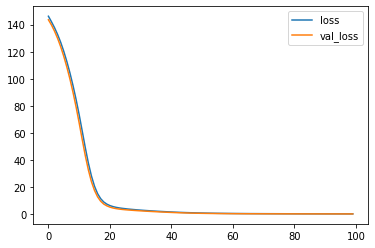

In [29]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### 【問題6】
#### MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [30]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float)[:, :, :, np.newaxis]
X_test = X_test.astype(np.float)[:, :, :, np.newaxis]
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


In [31]:
y_train = np.identity(10)[y_train]
y_val = np.identity(10)[y_val]
y_test = np.identity(10)[y_test]
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 10)
(12000, 10)
(10000, 10)


In [32]:
# モデル構築
import tensorflow.keras.layers as layers
K.clear_session()
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation = tf.nn.relu, input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation = tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation = tf.nn.softmax))
model.summary()

# コンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])

# 学習
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 27,994
Trainable params: 27,994
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 46s 948us/s

In [33]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred_proba", y_pred_proba[:5])
print("y_pred", y_pred)
print("y_test", np.argmax(y_test, axis=1))
print("test_acc", accuracy_score(np.argmax(y_test, axis=1), y_pred))

y_pred_proba [[1.2916088e-09 6.6264597e-08 7.4886488e-09 2.9229781e-07 5.8498592e-12
  4.2715078e-11 1.9714833e-16 9.9999952e-01 1.2345558e-09 1.7191481e-07]
 [1.4542872e-08 4.3511964e-06 9.9999297e-01 1.6282771e-06 3.3174841e-10
  9.4051997e-12 1.0032347e-06 1.6101337e-11 2.3446418e-09 2.5198368e-09]
 [9.7111055e-08 9.9992442e-01 5.5533076e-07 3.3952252e-09 3.0839205e-05
  4.1466046e-07 1.4558340e-07 6.1216347e-06 3.7472102e-05 4.6998277e-08]
 [1.0000000e+00 2.9455544e-12 1.8291066e-09 1.6199894e-12 6.2520336e-11
  3.0815041e-11 4.8991303e-08 2.8426128e-11 4.4245159e-09 1.7011955e-09]
 [2.2802447e-09 4.4857021e-10 2.7575282e-09 6.8324468e-10 9.9990833e-01
  9.4161146e-10 1.4230159e-09 6.0260206e-08 3.3191637e-07 9.1159360e-05]]
y_pred [7 2 1 ... 4 5 6]
y_test [7 2 1 ... 4 5 6]
test_acc 0.9814


### 【問題7】
#### （アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

Keras: (N, H, W, C)

PyTorch: (N, C, H, W)

In [83]:
# 【問題3】Iris（2値分類）
## 読み込み
df_iris = pd.read_csv('Iris.csv')
display(df_iris)
X = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 1:5])
y = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 5])
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
display(X.shape)
display(y.shape)

## 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

## 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


(100, 4)

(100, 1)

(64, 4) (64, 1)
(16, 4) (16, 1)
(20, 4) (20, 1)


In [84]:
# PyTorchでモデル構築
n_features = 4
n_nodes_1 = 10
activation_1 = nn.ReLU()
n_nodes_2 = 5
activation_2 = nn.ReLU()
n_output = 1
activation_output = nn.Sigmoid()

## ネットワーク
class NNfor2(nn.Module):
    
    def __init__(self):
        super(NNfor2, self).__init__()
        self.layer_1 = nn.Linear(
            n_features,
            n_nodes_1)
        self.layer_2 = nn.Linear(
            n_nodes_1,
            n_nodes_2)
        self.layer_output = nn.Linear(
            n_nodes_2,
            n_output)
    
    def forward(self, X):
        X = activation_1(self.layer_1(X))
        X = activation_2(self.layer_2(X))
        X = activation_output(self.layer_output(X))

        return X

## インスタンス作成
model = NNfor2()
print(model)

NNfor2(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_output): Linear(in_features=5, out_features=1, bias=True)
)


In [85]:
## ミニバッチ
batch_size = 1

## numpy配列をテンソルに変換
t_X_train = torch.from_numpy(X_train).float()
t_y_train = torch.from_numpy(y_train).float()
t_X_valid = torch.from_numpy(X_val).float()
t_y_valid = torch.from_numpy(y_val).float()

## 特徴量とラベルをデータセットにまとめる
dataset_train = TensorDataset(t_X_train, t_y_train)
dataset_valid = TensorDataset(t_X_valid, t_y_valid)

# データローダを作成
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [86]:
## オプティマイザ
lr = 0.003

optimizer = optim.Adam(
    model.parameters(),
    lr=lr
)

## 損失関数
criterion = nn.BCELoss()

In [87]:
## 学習(train)
def train_step(X_train, y_train):
    ## 訓練モード    
    model.train()

    ## 訓練データに対して予測
    y_train_pred = model(X_train)

    ## 勾配初期化
    optimizer.zero_grad()
    ## 損失の取得
    loss = criterion(y_train_pred, y_train)
    ## 勾配を計算
    loss.backward()

    ## パラメータ更新
    optimizer.step()

    ## 正解率の確認
    with torch.no_grad():
        y_train_pred_binary = torch.where(y_train_pred>0.5, torch.ones(1), torch.zeros(1))
        acc = (y_train_pred_binary == y_train).sum()

    return (loss.item(), acc.item())

## 評価(validation)
def valid_step(X_val, y_val):
    ## 評価モード
    model.eval()

    ## 予測
    y_val_pred = model(X_val)

    ## 損失計算
    loss = criterion(y_val_pred, y_val)

    ## 正解率計算
    with torch.no_grad():
        y_val_pred_binary = torch.where(y_val_pred>0.5, torch.ones(1), torch.zeros(1))
        acc = (y_val_pred_binary == y_val).sum()

    return (loss.item(), acc.item())

In [88]:
## パラメータ初期化関数
def initializer(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight)
        layer.bias.data.fill_(0.0)

## パラメータ初期化する
model.apply(initializer)

n_epoch = 10
train_history = []
val_history = []

# 1エポック内1データあたりの損失・正解率の平均
avg_loss = 0.0
avg_acc = 0.0
avg_val_loss = 0.0
avg_val_acc = 0.0

## 学習する
for epoch in range(n_epoch):
    ## epoch内のloss, accの保存
    total_loss = 0.0
    total_acc = 0.0
    total_val_loss = 0.0
    total_val_acc = 0.0
    ## 累計データ数の保存
    total_train = 0
    total_val = 0

    ## 訓練
    for X_train, y_train in loader_train:
       loss, acc = train_step(X_train, y_train)
       total_loss += loss
       total_acc += acc
       total_train += len(y_train)

    ## 評価
    for X_val, y_val in loader_valid:
        val_loss, val_acc = valid_step(X_val, y_val)
        total_val_loss += val_loss
        total_val_acc += val_acc
        total_val += len(y_val)

    # 平均計算
    avg_loss = total_loss/total_train
    avg_val_loss = total_val_loss/total_val
    avg_acc = total_acc/total_train
    avg_val_acc = total_val_acc/total_val

    print(f'epoch{epoch+1}/{n_epoch}: [loss:{avg_loss:.4f}, acc:{avg_acc:.4f}, val_loss:{avg_val_loss:.4f}, val_acc:{avg_val_acc:.4f}]')

    # リストに追加
    train_history.append(avg_loss)
    val_history.append(avg_val_loss)

print('Done!')
display(model.state_dict())

epoch1/10: [loss:0.6132, acc:0.7500, val_loss:0.2326, val_acc:1.0000]
epoch2/10: [loss:0.3086, acc:0.9062, val_loss:0.1296, val_acc:1.0000]
epoch3/10: [loss:0.2130, acc:0.9219, val_loss:0.0788, val_acc:1.0000]
epoch4/10: [loss:0.1675, acc:0.9219, val_loss:0.0566, val_acc:1.0000]
epoch5/10: [loss:0.1371, acc:0.9531, val_loss:0.0420, val_acc:1.0000]
epoch6/10: [loss:0.1167, acc:0.9688, val_loss:0.0352, val_acc:1.0000]
epoch7/10: [loss:0.0994, acc:0.9688, val_loss:0.0294, val_acc:1.0000]
epoch8/10: [loss:0.0867, acc:0.9531, val_loss:0.0261, val_acc:1.0000]
epoch9/10: [loss:0.0793, acc:0.9688, val_loss:0.0251, val_acc:1.0000]
epoch10/10: [loss:0.0710, acc:0.9688, val_loss:0.0210, val_acc:1.0000]
Done!


OrderedDict([('layer_1.weight',
              tensor([[ 0.5623,  0.6748, -0.6573,  0.7426],
                      [ 0.1654, -0.5562,  0.5469, -0.7611],
                      [-0.1390,  0.7942,  0.3495,  1.3400],
                      [ 0.5125, -0.2368, -1.6103, -0.6610],
                      [ 0.3432, -0.3872,  0.9416,  1.1465],
                      [-0.3240, -1.3878, -0.5829,  1.1936],
                      [-0.3032,  0.1143, -1.0057, -0.1303],
                      [-0.4265, -0.4313, -0.0837,  1.3517],
                      [ 0.1817, -0.0308,  0.2598, -0.2765],
                      [ 0.6418, -0.0529,  0.6314, -0.3959]])),
             ('layer_1.bias',
              tensor([ 0.0775,  0.0639,  0.0039,  0.2467,  0.3989,  0.2067,  0.1645,  0.1696,
                      -0.0546, -0.0508])),
             ('layer_2.weight',
              tensor([[-0.2276,  0.6432,  0.5755, -0.0767,  0.1582, -0.1999, -0.7034,  0.5008,
                       -0.8101,  0.2060],
                      [ 0.291

In [89]:
# 予測
## Tensor変換
t_X_test = torch.from_numpy(X_test).float()
t_y_test = torch.from_numpy(y_test).float()
y_pred_proba = model(t_X_test)
y_pred = torch.where(y_pred_proba>0.5, torch.ones(1), torch.zeros(1))
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred.flatten().int().detach().numpy())
print("y_test", y_test.flatten())

y_pred_proba tensor([[8.0147e-02],
        [9.9931e-01],
        [1.4008e-01],
        [9.9946e-01],
        [9.7083e-01],
        [9.9933e-01],
        [3.4314e-02],
        [9.4256e-01],
        [9.9908e-01],
        [9.9940e-01],
        [9.6409e-01],
        [9.8199e-01],
        [9.9781e-01],
        [3.9398e-02],
        [2.2401e-05],
        [2.6243e-04],
        [5.9972e-01],
        [2.0875e-03],
        [8.7462e-01],
        [1.4746e-02]], grad_fn=<SigmoidBackward>)
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


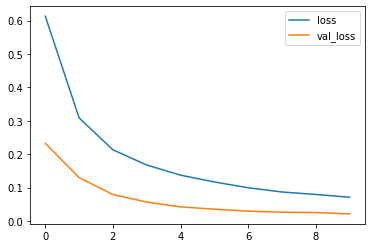

In [90]:
plt.plot(train_history, label="loss")
plt.plot(val_history, label="val_loss")
plt.legend()
plt.show()

In [97]:
# 【問題4】Iris（多値分類）をKerasで学習
# 抽出
X = np.array(df_iris.iloc[:, 1:5])
y = np.array(df_iris.iloc[:, 5])
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y[y=='Iris-setosa'] = 2
y = y.astype(np.int)
display(X.shape)
display(y.shape)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(150, 4)

(150,)

(96, 4) (96,)
(24, 4) (24,)
(30, 4) (30,)


In [98]:
# PyTorchでモデル構築
n_features = 4
n_nodes_1 = 100
activation_1 = nn.ReLU()
n_nodes_2 = 10
activation_2 = nn.ReLU()
n_output = 3

## ネットワーク
class NNfor4(nn.Module):
    
    def __init__(self):
        super(NNfor4, self).__init__()
        self.layer = nn.Sequential(nn.Linear(n_features, n_nodes_1), activation_1,
                                   nn.Linear(n_nodes_1, n_nodes_2), activation_2,
                                   nn.Linear(n_nodes_2, n_output))
    
    def forward(self, X):
        X = self.layer(X)

        return X

## インスタンス作成
model = NNfor4()
print(model)

NNfor4(
  (layer): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


In [99]:
## ミニバッチ
batch_size = 1

## numpy配列をテンソルに変換
t_X_train = torch.from_numpy(X_train).float()
t_y_train = torch.from_numpy(y_train).long()
t_X_valid = torch.from_numpy(X_val).float()
t_y_valid = torch.from_numpy(y_val).long()

## 特徴量とラベルをデータセットにまとめる
dataset_train = TensorDataset(t_X_train, t_y_train)
dataset_valid = TensorDataset(t_X_valid, t_y_valid)

# データローダを作成
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [100]:
## オプティマイザ
lr = 0.003

optimizer = optim.Adam(
    model.parameters(),
    lr=lr
)

## 損失関数
criterion = nn.CrossEntropyLoss()

In [101]:
## 学習(train)
def train_step(X_train, y_train):
    ## 訓練モード    
    model.train()

    ## 訓練データに対して予測
    y_train_pred = model(X_train)

    ## 勾配初期化
    optimizer.zero_grad()
    ## 損失の取得
    loss = criterion(y_train_pred, y_train)
    ## 勾配を計算
    loss.backward()

    ## パラメータ更新
    optimizer.step()

    ## 正解率の確認
    with torch.no_grad():
        y_train_pred_num = torch.argmax(y_train_pred, axis=1)
        acc = (y_train_pred_num == y_train).sum()

    return (loss.item(), acc.item())

## 評価(validation)
def valid_step(X_val, y_val):
    ## 評価モード
    model.eval()

    ## 予測
    y_val_pred = model(X_val)

    ## 損失計算
    loss = criterion(y_val_pred, y_val)

    ## 正解率計算
    with torch.no_grad():
        y_val_pred_num = torch.argmax(y_val_pred, axis=1)
        acc = (y_val_pred_num == y_val).sum()

    return (loss.item(), acc.item())

In [102]:
## パラメータ初期化関数
def initializer(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight)
        layer.bias.data.fill_(0.0)

## パラメータ初期化する
model.apply(initializer)

n_epoch = 10
train_history = []
val_history = []

# 1エポック内1データあたりの損失・正解率の平均
avg_loss = 0.0
avg_acc = 0.0
avg_val_loss = 0.0
avg_val_acc = 0.0

## 学習する
for epoch in range(n_epoch):
    ## epoch内のloss, accの保存
    total_loss = 0.0
    total_acc = 0.0
    total_val_loss = 0.0
    total_val_acc = 0.0
    ## 累計データ数の保存
    total_train = 0
    total_val = 0

    ## 訓練
    for X_train, y_train in loader_train:
       loss, acc = train_step(X_train, y_train)
       total_loss += loss
       total_acc += acc
       total_train += len(y_train)

    ## 評価
    for X_val, y_val in loader_valid:
        val_loss, val_acc = valid_step(X_val, y_val)
        total_val_loss += val_loss
        total_val_acc += val_acc
        total_val += len(y_val)

    # 平均計算
    avg_loss = total_loss/total_train
    avg_val_loss = total_val_loss/total_val
    avg_acc = total_acc/total_train
    avg_val_acc = total_val_acc/total_val

    print(f'epoch{epoch+1}/{n_epoch}: [loss:{avg_loss:.4f}, acc:{avg_acc:.4f}, val_loss:{avg_val_loss:.4f}, val_acc:{avg_val_acc:.4f}]')

    # リストに追加
    train_history.append(avg_loss)
    val_history.append(avg_val_loss)

print('Done!')
display(model.state_dict())

epoch1/10: [loss:0.4220, acc:0.8333, val_loss:0.4692, val_acc:0.7083]
epoch2/10: [loss:0.1982, acc:0.9271, val_loss:0.3541, val_acc:0.7917]
epoch3/10: [loss:0.1977, acc:0.9375, val_loss:0.3702, val_acc:0.7917]
epoch4/10: [loss:0.1370, acc:0.9479, val_loss:0.3252, val_acc:0.7917]
epoch5/10: [loss:0.1399, acc:0.9583, val_loss:0.2980, val_acc:0.8333]
epoch6/10: [loss:0.0975, acc:0.9479, val_loss:0.3033, val_acc:0.8750]
epoch7/10: [loss:0.0781, acc:0.9896, val_loss:0.2751, val_acc:0.9167]
epoch8/10: [loss:0.0720, acc:0.9688, val_loss:0.3611, val_acc:0.8333]
epoch9/10: [loss:0.0664, acc:0.9792, val_loss:0.3129, val_acc:0.8750]
epoch10/10: [loss:0.0540, acc:0.9896, val_loss:0.2127, val_acc:0.9167]
Done!


OrderedDict([('layer.0.weight',
              tensor([[ 1.0737e+00,  3.2816e-01,  1.3993e+00,  3.1433e-01],
                      [ 5.1457e-02, -2.1611e-01, -7.8271e-01,  3.1715e-01],
                      [-9.3054e-01,  2.1747e-01, -4.1210e-01,  8.2064e-01],
                      [-9.5670e-01,  4.0058e-02,  2.5462e-01, -4.8524e-01],
                      [-3.1320e-01, -1.2357e-01, -5.6607e-01, -8.4612e-01],
                      [ 7.6623e-01,  4.3919e-01, -1.9775e-01, -1.4759e-01],
                      [-5.0564e-01,  7.9602e-01, -9.8386e-01,  9.4235e-01],
                      [-6.1817e-01,  2.8316e-01,  6.6848e-01, -1.1235e+00],
                      [-4.4396e-02, -2.8688e-01, -9.5955e-01, -2.1558e-01],
                      [-1.2544e+00, -6.5028e-01, -6.0540e-02, -2.0199e-01],
                      [ 3.1921e-01, -3.4090e-01, -2.4880e-01, -4.0654e-01],
                      [-4.7069e-01, -5.6203e-01, -6.1135e-02,  1.1754e+00],
                      [ 1.7280e+00,  9.0811e-01, -2.6736

In [103]:
# 予測
## Tensor変換
t_X_test = torch.from_numpy(X_test).float()
t_y_test = torch.from_numpy(y_test).float()
y_pred_proba = model(t_X_test)
y_pred = torch.argmax(y_pred_proba, axis=1)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred.flatten().int().detach().numpy())
print("y_test", y_test.flatten())

y_pred_proba tensor([[ -0.3904,   7.3431,  -9.0218],
        [  7.8291,  -2.5207,  -1.4116],
        [  7.3435, -10.6116,  20.2460],
        [  1.6503,   3.9108,  -8.2561],
        [  7.5264,  -9.9605,  17.7605],
        [ -0.7256,   7.5182,  -9.0381],
        [  7.3173,  -9.9677,  18.5435],
        [  2.5831,  -0.5240,  -3.1900],
        [  3.7133,  -1.2928,  -3.7870],
        [  4.0105,  -2.1087,  -0.7720],
        [  2.0266,   2.6975,  -5.1263],
        [  1.9204,  -0.0820,  -2.5927],
        [  3.4710,  -0.9106,  -1.6805],
        [  2.7598,  -0.5410,  -3.4566],
        [  1.9932,   0.2545,  -2.9226],
        [  8.5846, -10.5887,  17.4398],
        [  1.8253,   0.7625,  -3.0284],
        [  4.7890,  -0.1446,  -2.2932],
        [  8.4944, -10.1296,  17.0702],
        [  6.7175,  -9.5578,  18.3562],
        [  0.4830,   5.5593,  -6.8502],
        [  3.1123,   0.5944,  -2.3812],
        [  7.8721,  -9.8401,  17.1046],
        [  9.7098, -11.4161,  18.6198],
        [  0.5327,   2.9287

In [43]:
# 【問題5】House PricesをKerasで学習

In [44]:
# 【問題6】MNISTをKerasで学習

### 【問題8】
#### （アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。


**《視点例》**


- 計算速度
- コードの行数・可読性
- 用意されている機能